In [1]:
! pip install pywph==1.0

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pywph as pw
import numpy as np
import torch
import scipy.optimize as opt
import time

Reason for being yanked: Wrong requirements.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
params = pd.read_csv('drive/MyDrive/camels data/params.csv')
nbody_file = np.load('drive/MyDrive/camels data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy')

In [4]:
full_params = params.loc[params.index.repeat(15)] # from len=1000 to len=15000
full_params = full_params.to_numpy()
wph_coeffs_1000 = np.load('drive/MyDrive/camels data/wph_coeffs.npy')

In [5]:
nbody_file.shape

(15000, 256, 256)

In [6]:
M = 256
N = 256
J = 7
L = 4
dn =0
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn)

if torch.cuda.is_available():
    wph_op.to(0)

data = np.log(nbody_file)

In [7]:
num = 1000
norm = None
#wph_coeffs_1000 = np.zeros((num*15,520),dtype='complex')

#for i in range(0,num):
#  if i%50==0: print(i)
#  test_coeff = wph_op(data[(i*15):(i*15+15)], pbc=True, norm=norm)
#  wph_coeffs_1000[(i*15):(i*15+15)] = test_coeff.cpu()

In [8]:
wph = wph_op(data[0], ret_wph_obj=True, norm=None)
S11_shape = (wph.get_coeffs("S11")[0].shape)[0]
S00_shape = (wph.get_coeffs("S00")[0].shape)[0]
S01_shape = (wph.get_coeffs("S01")[0].shape)[0]
C01_shape = (wph.get_coeffs("C01")[0].shape)[0]
Cphase_shape = (wph.get_coeffs("Cphase")[0].shape)[0]
L_shape = (wph.get_coeffs("L")[0].shape)[0]


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [10]:
real_coeffs = wph_coeffs_1000.real # use real part only here
imag_coeffs = wph_coeffs_1000.imag

#scaler = MinMaxScaler()
#real_coeffs = scaler.fit_transform(real_coeffs)
#full_params = scaler.fit_transform(full_params)

In [11]:
num_samples, num_params= np.shape(full_params)
num_samples, num_coeffs = np.shape(real_coeffs)
params_train, params_test, coeffs_train, coeffs_test = train_test_split(full_params,
                                                                        real_coeffs, test_size=0.1, random_state=42)


In [12]:
model = keras.Sequential([
    layers.Input(shape=(num_params,)),
    tf.keras.layers.BatchNormalization(synchronized=True),
    layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, kernel_regularizer='l1'),
    layers.Dense(num_coeffs)
])

In [13]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.00005)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
train = model.fit(params_train, coeffs_train, epochs=70, batch_size=16, validation_data=(params_test, coeffs_test))


Epoch 1/70
844/844 [==============================] - 6s 3ms/step - loss: 2.4630 - accuracy: 0.0260 - val_loss: 2.3353 - val_accuracy: 0.0873
Epoch 2/70
844/844 [==============================] - 2s 3ms/step - loss: 2.3124 - accuracy: 0.1317 - val_loss: 2.1941 - val_accuracy: 0.1787
Epoch 3/70
844/844 [==============================] - 2s 3ms/step - loss: 2.1800 - accuracy: 0.4739 - val_loss: 2.0724 - val_accuracy: 0.7200
Epoch 4/70
844/844 [==============================] - 2s 3ms/step - loss: 2.0688 - accuracy: 0.8850 - val_loss: 1.9710 - val_accuracy: 0.9760
Epoch 5/70
844/844 [==============================] - 2s 3ms/step - loss: 1.9680 - accuracy: 0.9967 - val_loss: 1.8654 - val_accuracy: 0.9973
Epoch 6/70
844/844 [==============================] - 2s 3ms/step - loss: 1.8469 - accuracy: 0.9980 - val_loss: 1.7305 - val_accuracy: 0.9973
Epoch 7/70
844/844 [==============================] - 2s 3ms/step - loss: 1.6985 - accuracy: 0.9980 - val_loss: 1.5807 - val_accuracy: 0.9973
Epoch 

In [14]:
predictions = model.predict(params_test)
loss = train.history['loss']
val_loss = train.history['val_loss']
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']

47/47 [==============================] - 0s 1ms/step


Text(0.5, 0, 'number of epochs')

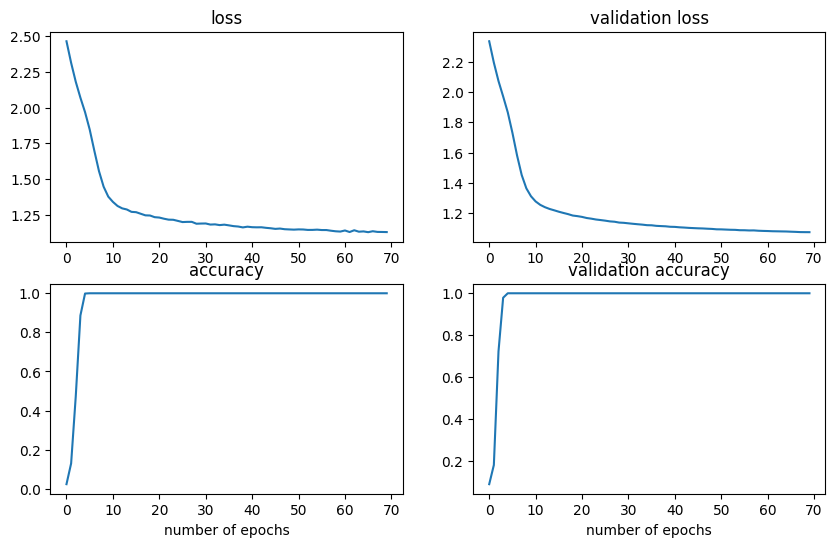

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0,0].plot(loss)
axs[0,1].plot(val_loss)
axs[1,0].plot(accuracy)
axs[1,1].plot(val_accuracy)

axs[0,0].set_title('loss')
axs[0,1].set_title('validation loss')
axs[1,0].set_title('accuracy')
axs[1,1].set_title('validation accuracy')

axs[1,0].set_xlabel('number of epochs')
axs[1,1].set_xlabel('number of epochs')

In [16]:
print(predictions.shape)
print(coeffs_test.shape)

(1500, 520)
(1500, 520)


In [17]:
# coefficients predicted
pd.DataFrame(predictions)

,0,1,2,3,4,5,6,7,8,9,...,510,511,512,513,514,515,516,517,518,519
0,0.007537,0.006629,0.007430,0.006853,0.010061,0.010021,0.010330,0.009929,0.014523,0.013943,...,0.226586,0.604548,0.062519,0.181823,0.048867,0.044137,0.021315,0.070452,0.007502,0.003861
1,0.008271,0.007413,0.008144,0.007620,0.010731,0.011619,0.011954,0.010968,0.017873,0.017781,...,1.069977,7.755744,0.116753,0.339040,0.250912,0.719738,0.040031,0.117324,0.025209,0.025116
2,0.007680,0.006491,0.007048,0.007383,0.008931,0.010040,0.010283,0.009473,0.015964,0.015946,...,0.712736,4.733057,0.096110,0.277830,0.160636,0.421643,0.035182,0.101639,0.017921,0.014324
3,0.008024,0.007461,0.008416,0.006955,0.011695,0.011386,0.011756,0.011251,0.016011,0.015506,...,0.495199,2.956721,0.076755,0.229163,0.090477,0.252271,0.025001,0.092582,0.014453,0.013481
4,0.006973,0.006423,0.007287,0.005980,0.010162,0.009626,0.009983,0.009651,0.013647,0.012988,...,0.223252,0.582932,0.061281,0.186823,0.048084,0.042852,0.020598,0.069890,0.007876,0.003160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.007502,0.006883,0.007766,0.006560,0.010726,0.010448,0.010848,0.010353,0.014982,0.014423,...,0.445331,2.473736,0.074524,0.224457,0.098528,0.222370,0.024264,0.082744,0.012430,0.010240
1496,0.008015,0.006989,0.007744,0.007405,0.010276,0.010656,0.010910,0.010379,0.015763,0.015361,...,0.353202,1.680651,0.070635,0.208328,0.074068,0.141636,0.025055,0.080450,0.009784,0.007804
1497,0.007207,0.006509,0.007348,0.006341,0.010124,0.009793,0.010128,0.009768,0.014012,0.013384,...,0.224678,0.592263,0.061844,0.184603,0.048490,0.043400,0.020921,0.070080,0.007733,0.003420
1498,0.007216,0.006342,0.007074,0.006576,0.009474,0.009613,0.009946,0.009430,0.014375,0.013917,...,0.384612,1.923999,0.073085,0.216587,0.093639,0.172752,0.025308,0.077263,0.010603,0.006529


In [18]:
pd.DataFrame(coeffs_test)

,0,1,2,3,4,5,6,7,8,9,...,510,511,512,513,514,515,516,517,518,519
0,0.008165,0.007658,0.008235,0.007365,0.010856,0.011350,0.011541,0.011199,0.014048,0.013869,...,0.161337,0.351930,0.055493,0.225228,0.043301,0.049841,0.027556,0.101846,0.009750,0.004905
1,0.008833,0.007979,0.008810,0.007918,0.010914,0.010835,0.010550,0.010612,0.015383,0.015136,...,2.098680,17.471416,0.169612,0.568619,0.433002,1.399376,0.061644,0.227077,0.052447,0.059791
2,0.010717,0.009510,0.010559,0.009578,0.012925,0.012477,0.012311,0.012211,0.017526,0.016510,...,0.862134,4.920386,0.089178,0.267304,0.138586,0.274989,0.024885,0.091255,0.010498,0.005714
3,0.008218,0.007481,0.008478,0.007650,0.011615,0.011549,0.011875,0.011868,0.016351,0.016089,...,0.079167,0.122706,0.022532,0.069362,0.007263,0.003063,0.005713,0.018027,0.000485,0.000050
4,0.004933,0.004322,0.005195,0.004353,0.006927,0.006692,0.008363,0.006954,0.009192,0.009251,...,0.047271,0.055071,0.025758,0.073245,0.008992,0.004274,0.008450,0.027531,0.000987,0.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.007032,0.006286,0.006834,0.006312,0.010542,0.010362,0.009953,0.010075,0.016607,0.016356,...,1.145268,7.074712,0.160995,0.412676,0.356740,0.963417,0.058255,0.179920,0.045211,0.044045
1496,0.009211,0.008091,0.009113,0.008416,0.012327,0.011889,0.012654,0.012934,0.016891,0.016996,...,0.241480,0.630703,0.055613,0.172288,0.047654,0.052343,0.013479,0.046944,0.002431,0.000599
1497,0.006090,0.005308,0.006365,0.005847,0.007955,0.007315,0.008679,0.009025,0.010522,0.009805,...,0.103270,0.181478,0.037463,0.145541,0.020432,0.015853,0.010006,0.041292,0.001355,0.000276
1498,0.005388,0.005080,0.005692,0.005086,0.007735,0.008108,0.008354,0.008103,0.012003,0.012696,...,0.383434,1.327353,0.076871,0.259537,0.079151,0.113702,0.028261,0.099875,0.009952,0.004922


Text(0.5, 1.0, 'real vs predicted parameters')

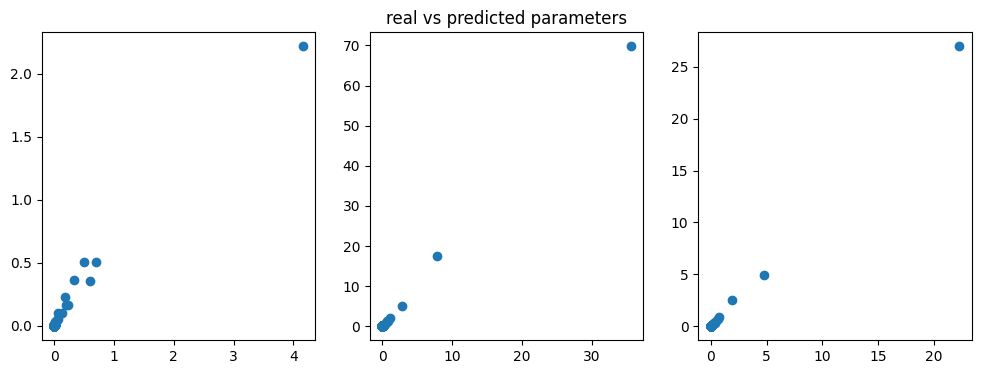

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(predictions[0],coeffs_test[0])
axs[1].scatter(predictions[1],coeffs_test[1])
axs[2].scatter(predictions[2],coeffs_test[2])

axs[1].set_title('real vs predicted parameters')


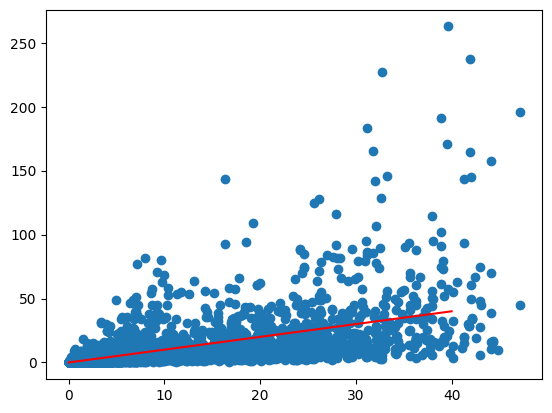

In [20]:
plt.scatter(predictions,coeffs_test)
x = np.linspace(0,40,41)
y = x
plt.plot(x,y,'r')